## Blend: a family of data augmentation techniques

During the last couple of years, a new set of data augmentation techniques that modify subregions of an image have been developed (cutout, mixup, ricap, cutmix, etc.), achieving state-of-the-art results in different datasets.
However, this is an area that still needs to be further developed, as it has great potential to improve performance.
I’d like to share with you a repo that contains a group of data augmentation techniques called blend, which contains many variations as you will see.
They are based on the idea that you can augment a dataset by masking, averaging or adding certain parts of an image. 

Many of the ideas I’ve integrated come from the original cutout, mixup, ricap and cutmix, as well as the CutMix > Mixup (?) and Progressive Sprinkles (cutout variation) - my new data augmentation & 98% on NIH Malaria dataset fastai threads. I’d like to specially thank @LessW2020 for creating those threads and sharing lots of creative ideas, @rwightman for his ‘frosted sprinkles’ idea, and Jeremy for bringing up ricap (I wasn’t aware of it).

I’ve reviewed the cutout, random erasing, mixup, ricap and cutmix papers and have extracted what they have in common. They all blend certain parts of the image with something else. 

- There are mainly 4 types of blend:

    - Zero: you mask a subregion in an image and set it to zero (black).
    - Noise: you mask a subregion in an image with random noise.
    - Mix: where you take a weighted average of 2 different regions of the same size.
    - Cut: you replace a certain region from an image with another region of the same size (this is similar to mix with weights of 0% for the input region and 100% for the cropping region).

- The size and number of modified regions also varies from the entire image, to a single smaller region to multiple regions. 

- In all these cases, the cropping region is either zero, noise or comes from another image. But it could also come from the same image (self blending the image). 

So I've decided to create a blend to be able to come up with a technique that is helpful in a given problem.

In [58]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
from fastai.vision import *

I've created some code we need to import to be able to use these new data augmentations with the fastai library. Hopefully, one day they will be part of the fastai library and won't need to do this.

In [60]:
from exp.nb_new_data_augmentation import *

In [61]:
size=128
bs = 32
partial_data = .05
path = untar_data(URLs.IMAGENETTE_160); path

PosixPath('/home/oguiza/.fastai/data/imagenette-160')

In [62]:
data = (ImageList.from_folder(path)
        .use_partial_data(partial_data)
        .split_by_folder(valid='val')
        .label_from_folder()
        .transform(size=size)
        .databunch(bs=bs, num_workers=4)
        .presize(size, scale=(0.35, 1))
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (642 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03445777,n03425413,n03028079,n03445777,n03425413
Path: /home/oguiza/.fastai/data/imagenette-160;

Valid: LabelList (27 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
n03000684,n03445777,n03394916,n01440764,n03425413
Path: /home/oguiza/.fastai/data/imagenette-160;

Test: None

## Blend parameters

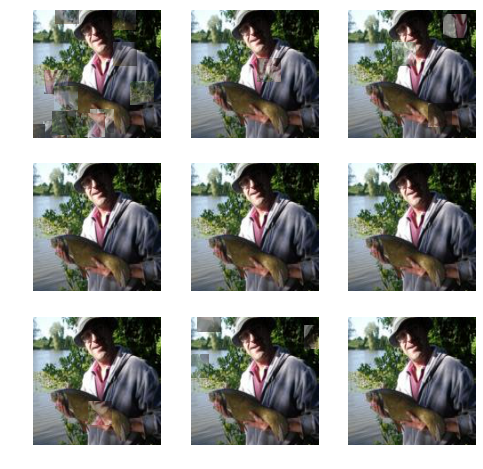

In [63]:
from exp.nb_new_data_augmentation import *
kwargs = {
    'size': .2,            # range(0.-1.) You can indicate the size of the patched area/s
    'alpha': .3,           # This is used to define a proba distribution
    'fixed_proba': 0,      # This overrides alpha. Will fix the % of the image that is modified
    'grid': False,         # Determine if patches may overlap or not. With True they do not overlap
    'blend_type': 'mix',   # Options: 'zero', 'noise', 'mix', 'cut', 'random'
    'same_size': True,     # All patches may have the same size or not
    'same_crop': False,    # Cropping patches are from the same subregion as input patches (only with 'mix' and 'cut')
    'same_image': True,   # Cropping patches will be from the same or different images (only with 'mix' and 'cut')
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Size

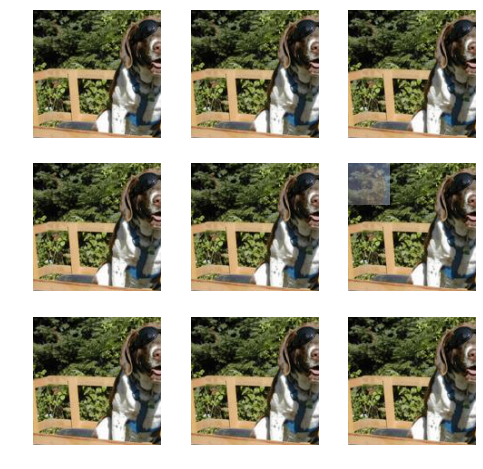

In [64]:
kwargs = {
    'size': .3, 
    'alpha': .2,
    'blend_type': 'mix', 
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Alpha

Alpha defines a beta distribution from where the probability that each patch is modified is chosen. With a higher alpha value, more patches will be modified.

You will notice that each image (from different batches) have a different mask out ratio. This is because we are applying a probability distribution, and not a fixed number.

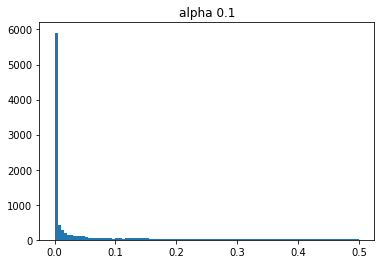

0.06035029798249979 0.11699671208793805


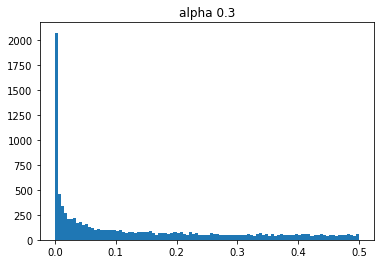

0.1440278954038348 0.15263658629566368


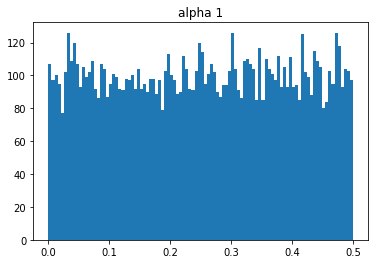

0.2511184050654034 0.1449260639678544


In [65]:
alpha = .1
x = np.random.beta(1, alpha, size=(10000, 1))
x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.title(f'alpha {alpha}')
plt.show()
print(x.mean(), x.std())

alpha = .3
x = np.random.beta(1, alpha, size=(10000, 1))
x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.title(f'alpha {alpha}')
plt.show()
print(x.mean(), x.std())

alpha = 1
x = np.random.beta(1, alpha, size=(10000, 1))
x = np.concatenate((x, 1 - x), axis=1).min(1)
plt.hist(x, 100)
plt.title(f'alpha {alpha}')
plt.show()
print(x.mean(), x.std())

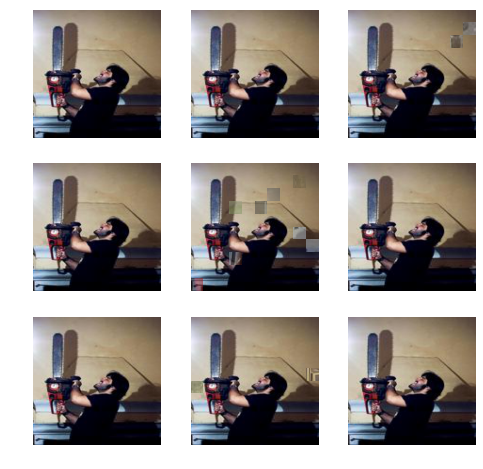

In [66]:
kwargs = {
    'size': .1, 
    'alpha': .1,
    'blend_type': 'mix', 
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

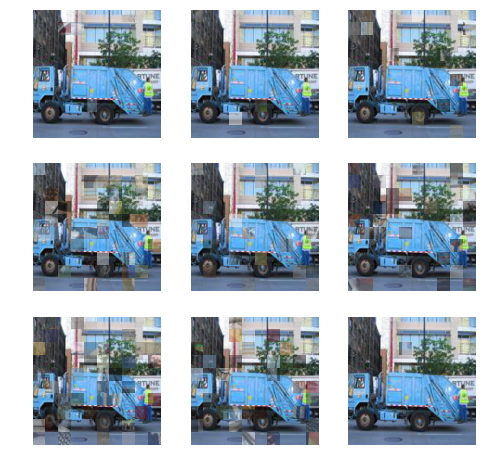

In [67]:
kwargs = {
    'size': .1, 
    'alpha': 1.,
    'blend_type': 'mix', 
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Fixed probability

However, if you want to apply a fixed probability, you can select fixed_probability and set it to any value between 0 and 1. This will override that alpha distribution. You will see that the distribution is now more stable.

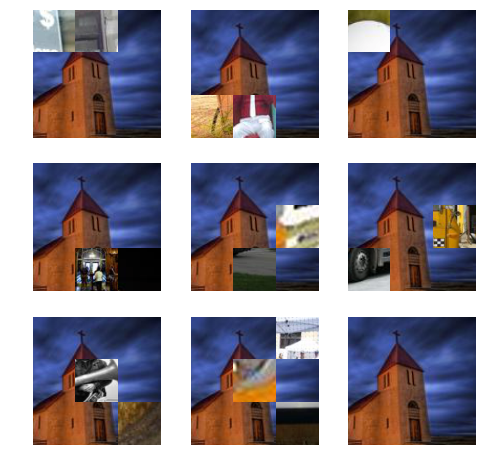

In [68]:
kwargs = {
    'size': .3, 
    'fixed_proba': .2,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Grid

By default, we want patches to be applied anywhere in the image. 
However, when we use 'mix' or 'blend' with same_image = False we want to avoid that patches overlap, as otherwise it'd be very difficult to calculate the output targets (proportional to each patch).

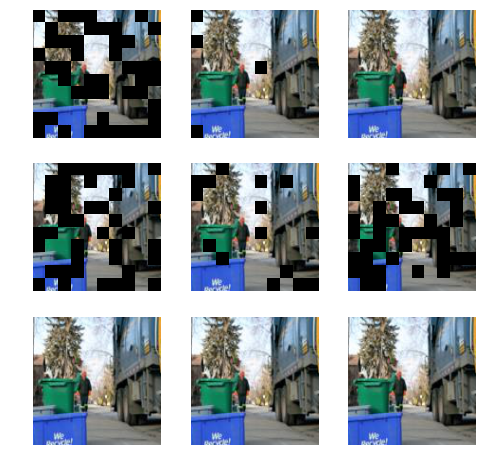

In [69]:
kwargs = {
    'size': .1, 
    'alpha': .2,
    'grid': True,
    'blend_type': 'zero', 
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

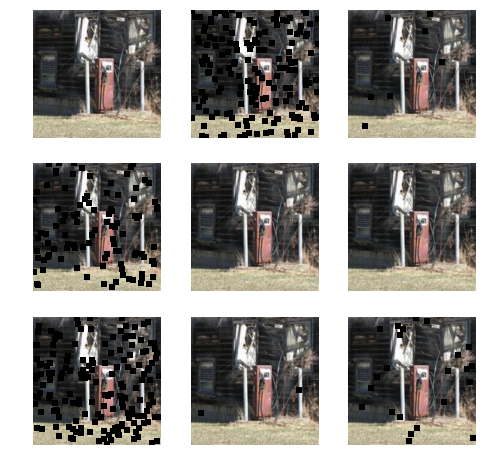

In [70]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'grid': False,
    'blend_type': 'zero', 
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Blend type

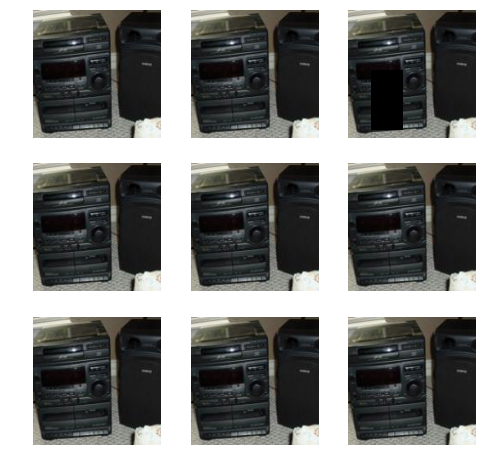

In [71]:
kwargs = {
    'size': .25,
    'alpha': .2,
    'blend_type': 'zero',  
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

These are similar to the  sprinkles idea raised by @LessW2020 [here](https://forums.fast.ai/t/progressive-sprinkles-cutout-variation-my-new-data-augmentation-98-on-nih-malaria-dataset/50454)

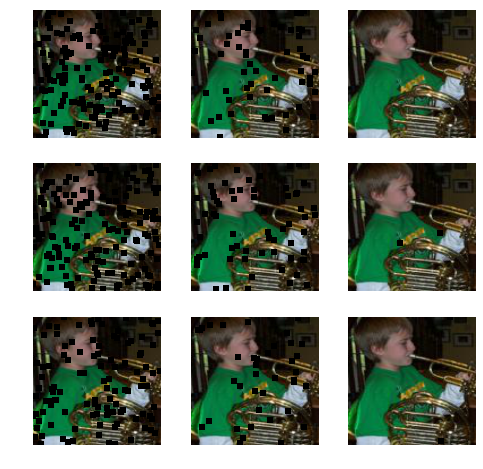

In [72]:
kwargs = {
    'size': .05,
    'alpha': .2,
    'blend_type': 'zero',  
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

And these are similar to the frosted sprinkles idea raised by @rwigtman [here](https://forums.fast.ai/t/progressive-sprinkles-cutout-variation-my-new-data-augmentation-98-on-nih-malaria-dataset/50454/2?u=oguiza)

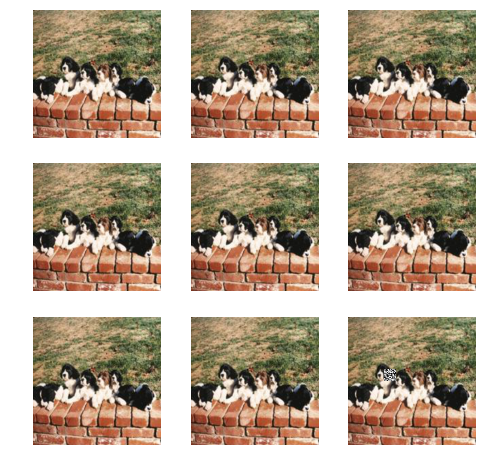

In [73]:
kwargs = {
    'size': .1,
    'alpha': .2,
    'blend_type': 'noise',  
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

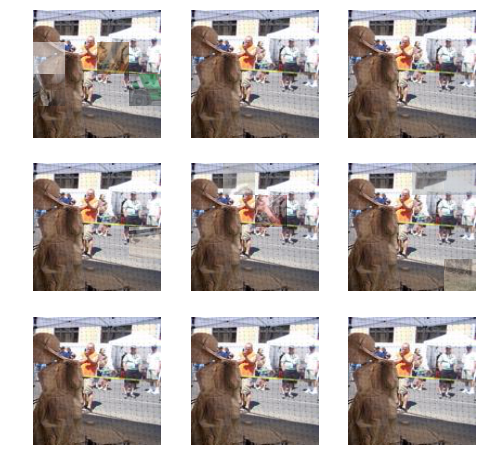

In [74]:
kwargs = {
    'size': .25,
    'alpha': .2,
    'blend_type': 'mix',  
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

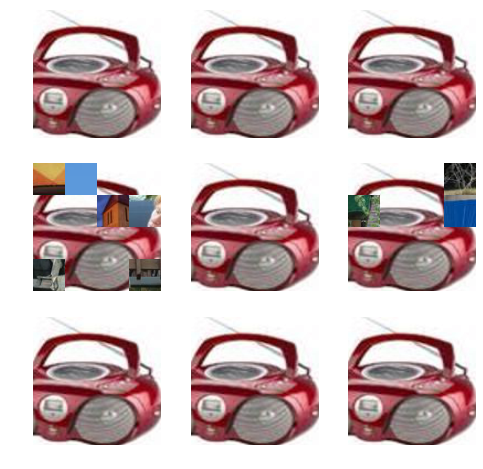

In [75]:
kwargs = {
    'size': .25,
    'alpha': .2,
    'blend_type': 'cut',  
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

There's even a random choice that will randomly choose the blend type by batch.

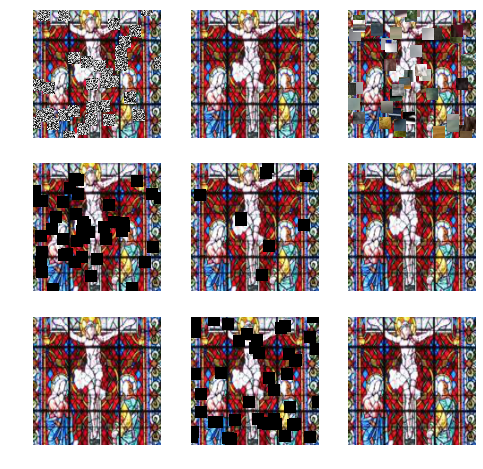

In [76]:
kwargs = {
    'size': .1,
    'alpha': .2,
    'blend_type': 'random',  
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Same size

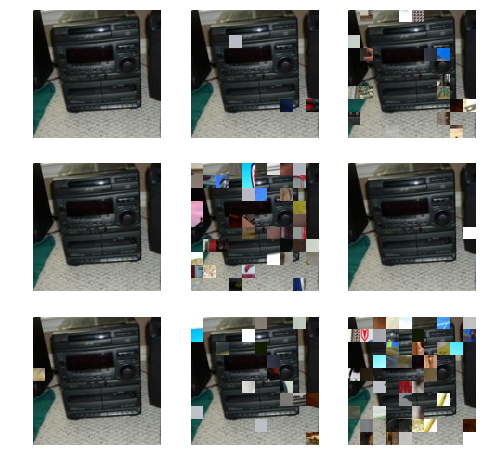

In [77]:
kwargs = {
    'size': .1,
    'alpha': .3, 
    'blend_type': 'cut', 
    'same_size': True,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

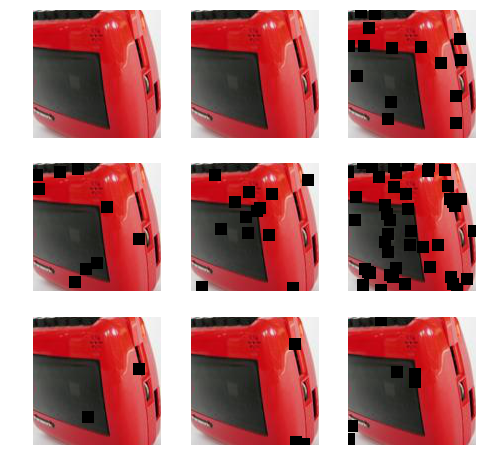

In [78]:
kwargs = {
    'size': .1,
    'alpha': .3, 
    'blend_type': 'zero', 
    'same_size': False,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Same crop

This allows to select whether the subregion of the cropping patch is the same as in the initial image or not

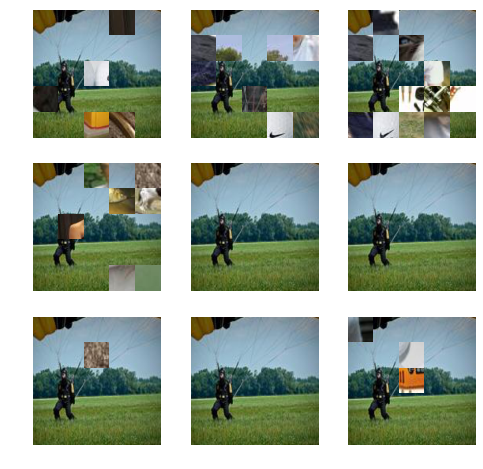

In [79]:
kwargs = {
    'size': .2,
    'alpha': .3, 
    'blend_type': 'cut', 
    'same_crop': True,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

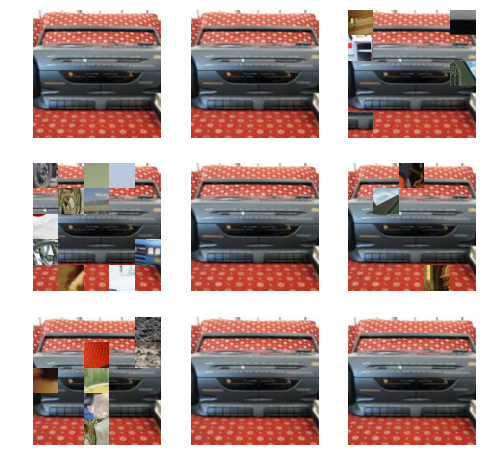

In [80]:
kwargs = {
    'size': .2,
    'alpha': .3, 
    'blend_type': 'cut', 
    'same_crop': False,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

### Same image

This allows you to decide with blend_type 'mix' or 'cut' if the cropping region should come from the same image (self-blended) or a different one randomly selected. So if set to true, the coordinates of the cropping region will be the same as in the image where it will be patched. 
If set to True, the same_crop value will need to be set to False, otherwise you will be clipping a subregion from an image, and pasting it on the same region and image, without any change from the initial image.

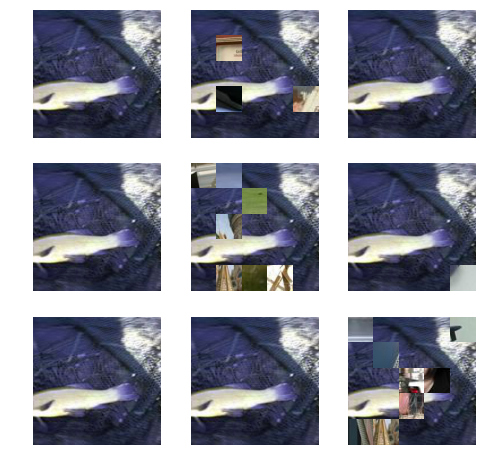

In [81]:
kwargs = {
    'size': .2,
    'alpha': .3, 
    'blend_type': 'cut', 
    'same_image': False,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

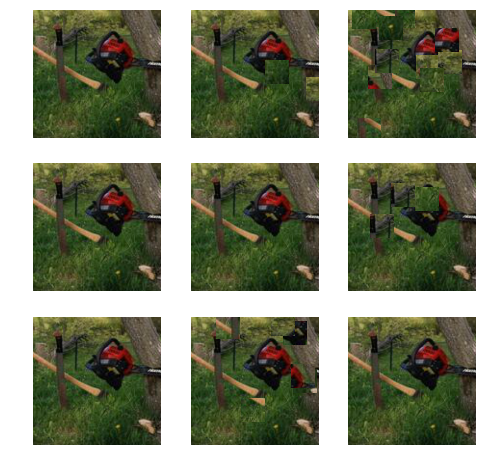

In [82]:
kwargs = {
    'size': .2,
    'alpha': .3, 
    'blend_type': 'cut', 
    'same_crop': False,
    'same_image': True,
}
learn = Learner(data,models.resnet34()).blend(**kwargs).show_multi_img_tfms()

## Progressive blend

There was also a very iteresting idea raised by @LessW2020 that is to modify certain parameters of the transformation as training progresses. 
To be able to do that I have build another callback that manages parameters from transformations (single-image transform or multi-image transform). I call it TFMScheduler. Here is how if works.

Let's say we create a learner with a certain transformation (mixup) and we want to modify the alpha parameter during training, to make it progressively harder. 

1. We create the learner
2. We select the desired image transformation (in this case mixup)
3. Select sch_param: schduled parameter (in our example 'alpha')
4. Select the range of values it should have (if the first is 0, we can just enter the last value)
5. Select the range of iterations where the value will go from min to maximum
6. Select the function that will determine how the change occurs
7. Plot is just to be able to see how the parameter will evolve
8. Test is to be able to check that it works as we expect before training it

Once you are happy with the result, you can set test to False and start training with a scheduled parameter

### Single parameter


 alpha between 0.0 and 0.5 in iters 0.00 to 1.00


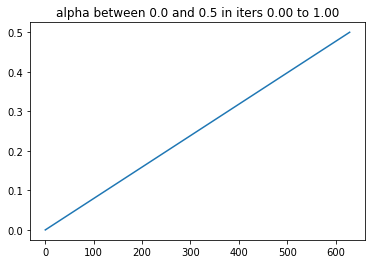

epoch,train_loss,valid_loss,accuracy,time


In [83]:
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = mixup

sch_param='alpha'
sch_val = .5
sch_iter = None  # If None it will take all the iterations
sch_func = None # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)

learn.callback_fns.append(sch_tfm_cb)
learn.fit_one_cycle(30)


 alpha between 0.2 and 0.5 in iters 0.00 to 1.00


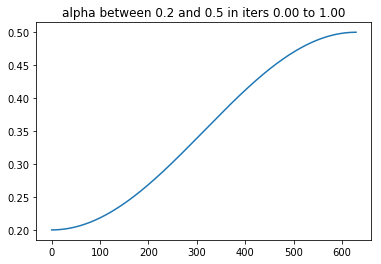

epoch,train_loss,valid_loss,accuracy,time


In [84]:
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = mixup

sch_param='alpha'
sch_val = (.2, .5)  # You can also enter a tuple of values (min, max)
sch_iter = None  # 
sch_func = annealing_cos # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)

learn.callback_fns.append(sch_tfm_cb)
learn.fit_one_cycle(30)


 alpha between 0.0 and 0.5 in iters 0.30 to 0.70


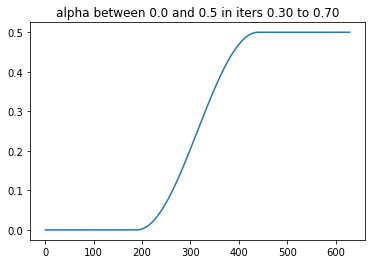

epoch,train_loss,valid_loss,accuracy,time


In [85]:
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = mixup

sch_param='alpha'
sch_val = .5   # You can also enter a tuple of values (min, max)
sch_iter = (.3, .7)  # And a tuple with start and end iteration percentage
sch_func = annealing_cos # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)

learn.callback_fns.append(sch_tfm_cb)
learn.fit_one_cycle(30)

As you can see the scheduling function changes how the shape of the evolution


 alpha between 0.0 and 0.5 in iters 0.00 to 1.00


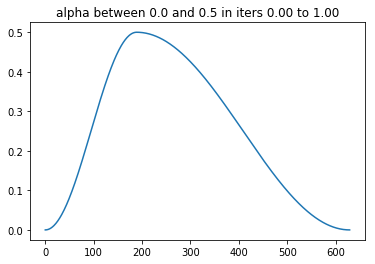

epoch,train_loss,valid_loss,accuracy,time


In [86]:
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = mixup

sch_param='alpha'
sch_val = .5   # You can also enter a tuple of values (min, max)
sch_iter = None  # And a tuple with start and end iteration percentage
sch_func = cosine_annealing # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)

learn.callback_fns.append(sch_tfm_cb)
learn.fit_one_cycle(30)

If you want to change more than 1 parameters at the same time you can also do it this way. Let's say we want to modify size and fixed_proba in the blend data augmentation.


 size between 0.05 and 2.0 in iters 0.00 to 1.00


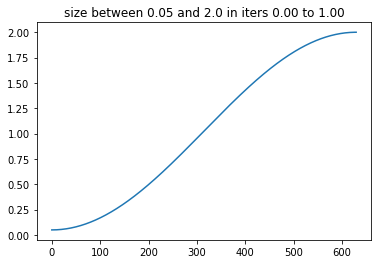


 fixed_proba between 0.0 and 0.2 in iters 0.00 to 1.00


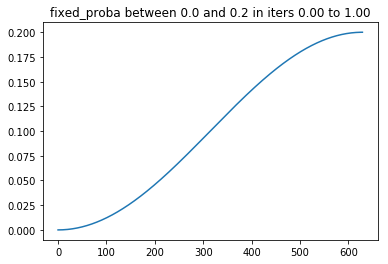

epoch,train_loss,valid_loss,accuracy,time


In [87]:
learn = Learner(data, models.resnet34(), metrics=accuracy)

tfm_fn = partial(blend, blend_type='zero')

sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a tuple of values (min, max)
sch_iter = None  # And a tuple with start and end iteration percentage
sch_func = annealing_cos # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)

learn.callback_fns.append(sch_tfm_cb)
learn.fit_one_cycle(30)

If required, you can also pass more different sch_iter and/or sch_func for each parameter. 

### Multiple parameters

So now you can easily build many types of data transformations using blend and the TfmScheduler. I hope you find this useful!


 size between 0.05 and 2.0 in iters 0.00 to 0.29


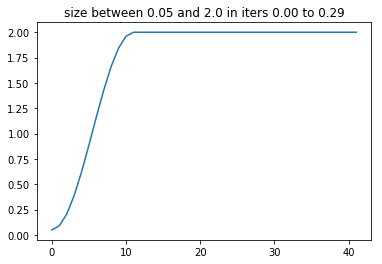


 fixed_proba between 0.0 and 0.19954 in iters 0.00 to 0.69


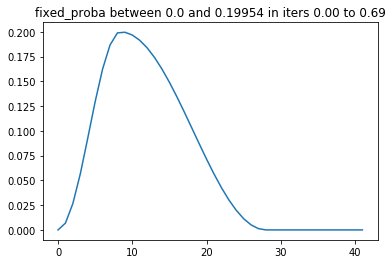

epoch,train_loss,valid_loss,accuracy,time


In [88]:
from exp.nb_new_data_augmentation import *

# Create learner
learn = Learner(data, models.resnet34(), metrics=accuracy)

# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

learn.fit_one_cycle(2)

So if you are interested, you can now create your own transforms combining all types of parameters in addition to mixup, ricap and cutmix. Good luck with your experiments!